<a href="https://colab.research.google.com/github/guinetik/python-ds/blob/master/sentiment_classifier.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Python imports

In [218]:
!pip install pydot
!pip install -U bokeh
!pip install python-louvain

In [217]:
# Bibliotecas básicas
from enum import Enum
import csv
import random
import re
import string
import uuid
# Bibliotecas de terceiros
from abc import ABC, abstractmethod
import matplotlib as mpl
import matplotlib.pyplot as plt
import seaborn as sns
#Data science
import numpy as np
import pandas as pd
# NLP
import nltk
from nltk.corpus import stopwords
from nltk.stem.porter import PorterStemmer
# Bibliotecas para comunidade de grafos
import networkx as nx
import community.community_louvain as community_louvain
from networkx.algorithms import community
# Bibliotecas do scikit-learn
from sklearn.ensemble import RandomForestClassifier
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_selection import SelectKBest, chi2
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix, f1_score, roc_curve, auc, roc_auc_score
from sklearn.model_selection import train_test_split
from sklearn.neighbors import KNeighborsClassifier
from sklearn.preprocessing import MinMaxScaler
from sklearn.tree import DecisionTreeClassifier, export_graphviz
# Bibliotecas do Bokeh
from bokeh.io import output_notebook, show, save
from bokeh.models import Circle, MultiLine, Range1d, ColumnDataSource, HoverTool, EdgesAndLinkedNodes, NodesAndLinkedEdges
from bokeh.palettes import Blues8, Reds8, Purples8, Oranges8, Viridis8, Spectral8, Plasma256, d3, Turbo256
from bokeh.plotting import figure, from_networkx
from bokeh.transform import linear_cmap
from bokeh.palettes import Category20
from bokeh.models import Arrow, NormalHead
# Bibliotecas para processamento paralelo
from multiprocessing import Pool, cpu_count
from joblib import Parallel, delayed
#
output_notebook()
nltk.download('stopwords')

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


True

# Classifier Code

In [9]:
#
def process_row(row, classifier):
    colab_user_id = row[0]
    description = row[1]
    prediction = classifier.model.predict(description)
    score = prediction['score']

    if colab_user_id not in classifier.user_scores:
        classifier.user_scores[colab_user_id] = []

    classifier.user_scores[colab_user_id].append(score)
#
class ModelType(Enum):
  RANDOM_FOREST = 'RandomForest'
  LOGISTIC_REGRESSION = 'LogisticRegression'
  DECISION_TREE = 'DecisionTree'
  KNN = 'KNN'
#
#
class SentimentClassifierModel:
    def __init__(self, train_file_url):
        self.train_file_url = train_file_url
        self.data = None
        self.cv = CountVectorizer()
        self.trained_models = {}
        self.current_model = None
    #
    def load_data(self):
        self.data = pd.read_csv(self.train_file_url, low_memory=False)
    #
    @staticmethod
    def sanitize_phrase(phrase):
        stopwords_set = set(stopwords.words('portuguese'))
        result = ""
        for word in phrase.split(" "):
            review = re.sub(r'[^ \nA-Za-z0-9À-ÖØ-öø-ÿ/]+', ' ', word)
            review = review.lower()
            review = review.split()
            ps = PorterStemmer()
            # Stemming
            review = [ps.stem(word) for word in review if word not in stopwords_set]
            if review and len(review[0]) > 2:
                result += review[0] + " "
        return result.strip()
    #
    def vectorize_data(self):
        self.cv = CountVectorizer(stop_words=stopwords.words('portuguese'))
        words = self.cv.fit_transform(self.data.description)
        self.x = words.toarray()
        self.y = self.data.iloc[:, 1]
    #
    def train_model(self, model_type=ModelType.RANDOM_FOREST):
        x_train, x_valid, y_train, y_valid = train_test_split(self.x, self.y, test_size=0.25, random_state=42)
        sc = MinMaxScaler()
        x_train = sc.fit_transform(x_train)
        x_valid = sc.transform(x_valid)
        #
        if model_type == ModelType.RANDOM_FOREST:
            model = RandomForestClassifier()
        elif model_type == ModelType.LOGISTIC_REGRESSION:
            model = LogisticRegression()
        elif model_type == ModelType.DECISION_TREE:
            model = DecisionTreeClassifier()
        elif model_type == ModelType.KNN:
            model = KNeighborsClassifier()
        else:
            raise ValueError("Invalid model_type. Supported values: 'RandomForest', 'LogisticRegression', "
                             "'DecisionTree', 'KNN'")

        model.fit(x_train, y_train)
        y_pred = model.predict(x_valid)
        print("Training Accuracy:", model.score(x_train, y_train))
        print("Validation Accuracy:", model.score(x_valid, y_valid))
        print("F1 score:", f1_score(y_valid, y_pred, average="weighted"))
        cm = confusion_matrix(y_valid, y_pred)
        print(cm)
        #
        self.trained_models[model_type] = model
        self.current_model = model_type
    #
    def predict(self, phrase, model_type=None):
        if model_type is None:
            model_type = self.current_model
        else:
            if model_type not in ModelType:
                raise ValueError("Invalid model_type. Supported values: 'RandomForest', 'LogisticRegression', "
                                 "'DecisionTree', 'KNN'")
            if model_type not in self.trained_models:
                raise ValueError(f"Model '{model_type.value}' has not been trained yet.")
        #
        model = self.trained_models[model_type]
        phrase = self.sanitize_phrase(phrase)
        vectorized_phrase = self.cv.transform([phrase]).toarray()
        sentiment_score = model.predict(vectorized_phrase)[0]
        #
        return {'status': 'ok', 'score': sentiment_score, 'model': model_type.value}
#
#
class ColabSentimentClassifier:
    def __init__(self, events_file_url, model_train_file_url):
        self.events_file_url = events_file_url
        self.model = SentimentClassifierModel(train_file_url=model_train_file_url)
        self.user_scores = {}
    #
    def process(self):
        self.load_events_data()
        self.initialize_model()
        self.update_user_scores()
    #
    def load_events_data(self):
        colab_events = pd.read_csv(self.events_file_url)
        self.events_data = colab_events[['user_id', 'description']]
    #
    def initialize_model(self):
        self.model.load_data()
        self.model.vectorize_data()
        self.model.train_model(model_type=ModelType.RANDOM_FOREST)
    #
    def calculate_user_scores(self):
        for colab_user_id, scores in self.user_scores.items():
            total_events = len(scores)
            aggregate_score = sum(scores) / total_events if total_events > 0 else 0
            normalized_score = (aggregate_score - 1) / (10 - 1)
            self.user_scores[colab_user_id] = normalized_score
    #
    def get_user_scores(self):
      user_scores_copy = self.user_scores.copy()
      scores = list(user_scores_copy.values())
      scaler = MinMaxScaler()
      scaled_scores = scaler.fit_transform(np.array(scores).reshape(-1, 1))
      user_scores_df = pd.DataFrame(scaled_scores, index=user_scores_copy.keys(), columns=['scores'])
      user_scores_df.index.name = 'colab_user_id'
      return user_scores_df
    #
    def update_user_scores(self):
        for row in self.events_data.itertuples(index=False):
            process_row(row, self)

        self.calculate_user_scores()
    #
    def plot_user_scores(self):
        user_ids = list(self.user_scores.keys())
        scores = list(self.user_scores.values())
        #
        plt.bar(user_ids, scores)
        plt.xlabel('User ID')
        plt.ylabel('Normalized Score')
        plt.title('Sentiment Scores per User')
        plt.xticks(rotation='vertical')
        plt.show()
#
#
def main(events_file_path, model_train_file_path):
    classifier = ColabSentimentClassifier(events_file_url=events_file_path, model_train_file_url=model_train_file_path)
    classifier.process()
    classifier.plot_user_scores()
#
#
def DownloadDataFrame(df, filename):
  df.to_csv(filename, encoding = 'utf-8-sig', index=False, quoting=csv.QUOTE_NONNUMERIC)
  files.download(filename)
#

# Load Data

In [10]:
## 2022 files
#events_file_path = "https://drive.google.com/uc?id=1EN-RuRUjnMCiMzzjcEqcjMLMCBGRYU6b&export=download" # all files
#events_file_path = "https://drive.google.com/uc?id=1NFN0XGFLixnkIgL5TU7joEIi9WbOsGZE&export=download" #sample file
#model_train_file_path = "https://drive.google.com/uc?id=1h2ti-z-trZOHfZiUJTCSbTW5CeowZVxz&export=download"
#colab_users_url = "https://drive.google.com/uc?id=1_rgS5CtYDFbU5viohhJueVKBz7C4zS7h&export=download"
#colab_followers_url = "https://drive.google.com/uc?id=1v7ex9cCzlyMMUjy-rZQuBCruXTXVVVSv&export=download"
##2023-files
events_file_path = "https://drive.google.com/uc?id=1NFN0XGFLixnkIgL5TU7joEIi9WbOsGZE&export=download" #sample file
model_train_file_path = "https://drive.google.com/uc?id=1h2ti-z-trZOHfZiUJTCSbTW5CeowZVxz&export=download"
colab_users_url = "https://drive.google.com/uc?id=1k6FtBdAaCGTiTJKrzDFURfkNMqiCx4cr&export=download"
colab_followers_url = "https://drive.google.com/uc?id=1GVIcUexwK0T83QIamzbbUtALFTviB-t8&export=download"

In [11]:
colab_events = pd.read_csv(events_file_path)
colab_events = colab_events[['user_id', 'description']]
colab_events.head(1)

,user_id,description
0,219046.0,Conforme relatado anteriormente no protocolo d...


In [12]:
colab_users = pd.read_csv(colab_users_url)
print(colab_users.head(1))

   id gender  birth_date  city_id city_name  state_id  state_name  created_at  \
0   1   male  1982-06-28     2916    Recife        16  Pernambuco  03/03/2013   

  last_sign_in_at device     lat        lng  
0      12/05/2020     -1 -7.8945 -34.883833  


In [13]:
colab_followers = pd.read_csv(colab_followers_url)
print(colab_followers.shape)
print(colab_followers.head(1))

(160052, 5)
   source  target        created_at        updated_at deleted_at
0       1      70  2014-03-28 18:21  2014-03-28 18:21        NaN


# Run classifier model

In [14]:
classifier = ColabSentimentClassifier(events_file_url=events_file_path, model_train_file_url=model_train_file_path)
classifier.process()

#classifier.plot_user_scores()
#main(events_file_path, model_train_file_path)

Training Accuracy: 0.9745734359317497
Validation Accuracy: 0.18655967903711135
F1 score: 0.14865114644315586
[[0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 ...
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]]


In [15]:
users_scores = classifier.get_user_scores()
users_scores.head(10)
print(users_scores)

                 scores
colab_user_id          
219046.0       0.211152
43341.0        0.205052
122640.0       0.264802
160035.0       0.209818
325627.0       0.336923
...                 ...
345078.0       0.061679
214770.0       0.061609
172012.0       0.635814
301900.0       0.061609
151137.0       0.046523

[781 rows x 1 columns]


# Top X Bottom Scores

In [16]:
top_scores = users_scores.nlargest(10, 'scores')
bottom_scores = users_scores.nsmallest(10, 'scores')

print("Top Scores:")
print(top_scores)
print("Bottom Scores:")
print(bottom_scores)

Top Scores:
                 scores
colab_user_id          
689192.0       1.000000
495167.0       0.992761
277625.0       0.991061
205132.0       0.966655
270448.0       0.812484
159688.0       0.812484
407061.0       0.805649
77592.0        0.721421
493458.0       0.715946
492465.0       0.714503
Bottom Scores:
                 scores
colab_user_id          
55528.0        0.000000
1622.0         0.000962
236340.0       0.004187
304910.0       0.004187
331850.0       0.005360
4976.0         0.005838
236818.0       0.007840
6579.0         0.008168
6764.0         0.008437
13040.0        0.017561


In [17]:
top_score_events = colab_events.loc[colab_events['user_id'] == 689192]
top_score_events.head(10)

,user_id,description
604,689192.0,essa rua está precisando concreto urgente!!!! ...


In [18]:
bottom_score_events = colab_events.loc[colab_events['user_id'] == 175658]
bottom_score_events.head(10)

,user_id,description
565,175658.0,"Parece brincadeira, mas não é: os representant..."


# Data plots

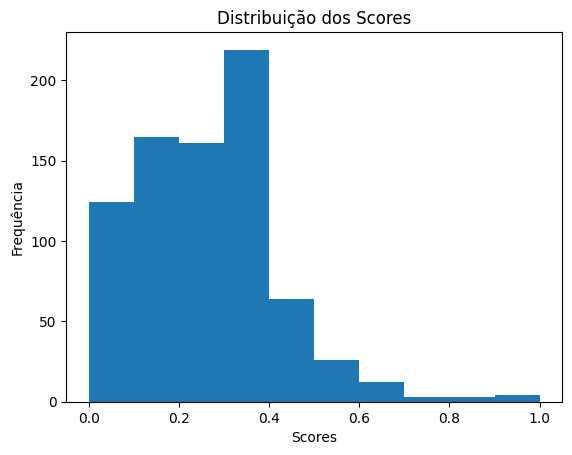

In [19]:
plt.hist(users_scores['scores'], bins=10)
plt.xlabel('Scores')
plt.ylabel('Frequência')
plt.title('Distribuição dos Scores')
plt.show()

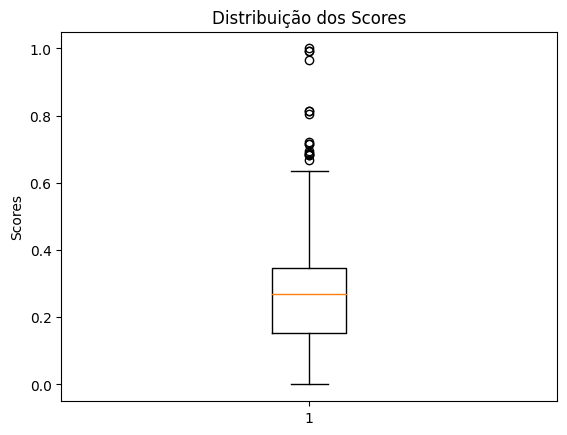

In [20]:
plt.boxplot(users_scores['scores'])
plt.ylabel('Scores')
plt.title('Distribuição dos Scores')
plt.show()

In [32]:
# Calcula o total de postagens por usuário no dataframe colab_events
postagens_por_usuario = colab_events.groupby('user_id').size().reset_index(name='total_postagens')

# Combina o dataframe user_scores com o total de postagens por usuário
user_scores_com_postagens = users_scores.merge(postagens_por_usuario, left_on='colab_user_id', right_on='user_id', how='left')

# Exibe o dataframe resultante
print(user_scores_com_postagens)

       scores   user_id  total_postagens
0    0.211152  219046.0                2
1    0.205052   43341.0                7
2    0.264802  122640.0                1
3    0.209818  160035.0                2
4    0.336923  325627.0                1
..        ...       ...              ...
776  0.061679  345078.0                1
777  0.061609  214770.0                1
778  0.635814  172012.0                1
779  0.061609  301900.0                1
780  0.046523  151137.0                1

[781 rows x 3 columns]


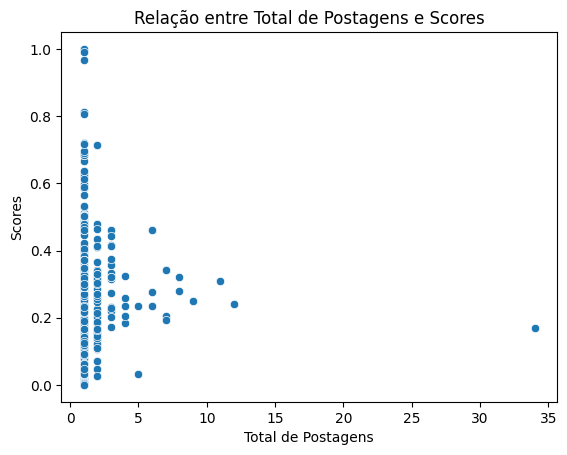

In [33]:
# Criar o gráfico de dispersão
sns.scatterplot(data=user_scores_com_postagens, x='total_postagens', y='scores')

# Configurar os rótulos dos eixos
plt.xlabel('Total de Postagens')
plt.ylabel('Scores')
plt.title('Relação entre Total de Postagens e Scores')

# Exibir o gráfico
plt.show()

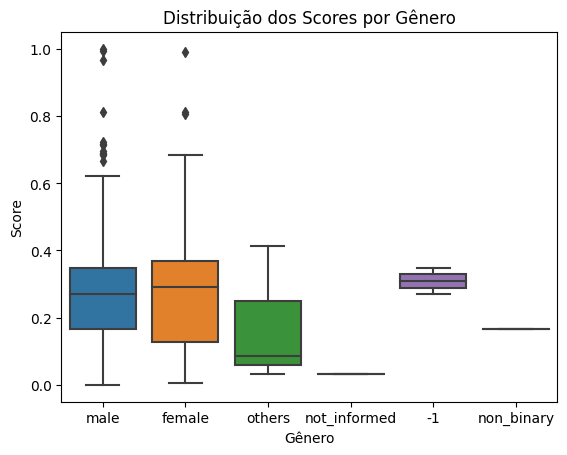

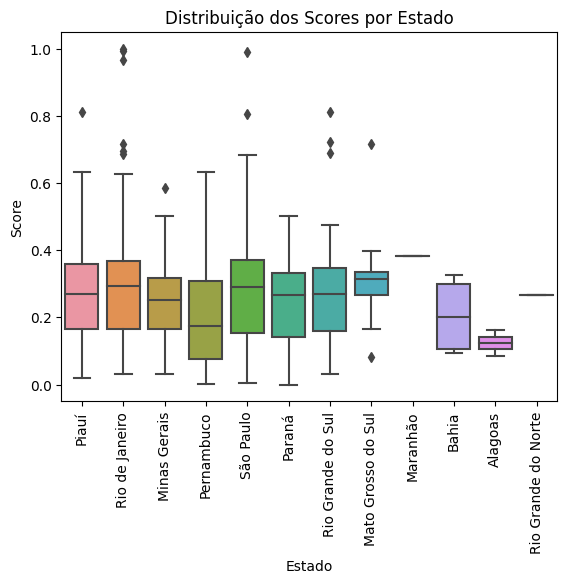

In [34]:
user_scores_com_postagens = user_scores_com_postagens.rename(columns={'user_id': 'id'})
# Boxplot dos scores por gênero
sns.boxplot(x='gender', y='scores', data=user_scores_com_postagens.merge(colab_users, on='id'))
plt.xlabel('Gênero')
plt.ylabel('Score')
plt.title('Distribuição dos Scores por Gênero')
plt.show()

# Boxplot dos scores por estado
sns.boxplot(x='state_name', y='scores', data=user_scores_com_postagens.merge(colab_users, on='id'))
plt.xlabel('Estado')
plt.ylabel('Score')
plt.title('Distribuição dos Scores por Estado')
plt.xticks(rotation='vertical')
plt.show()

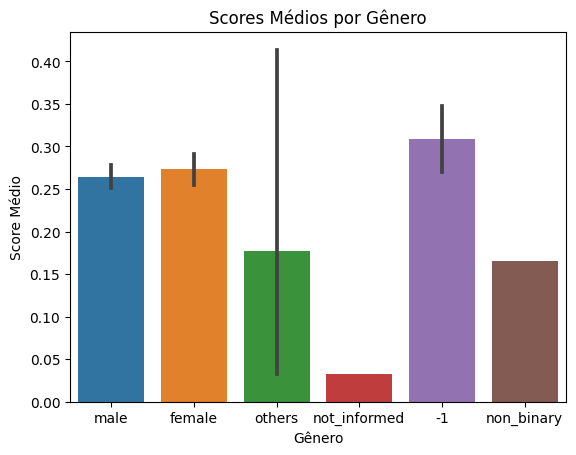

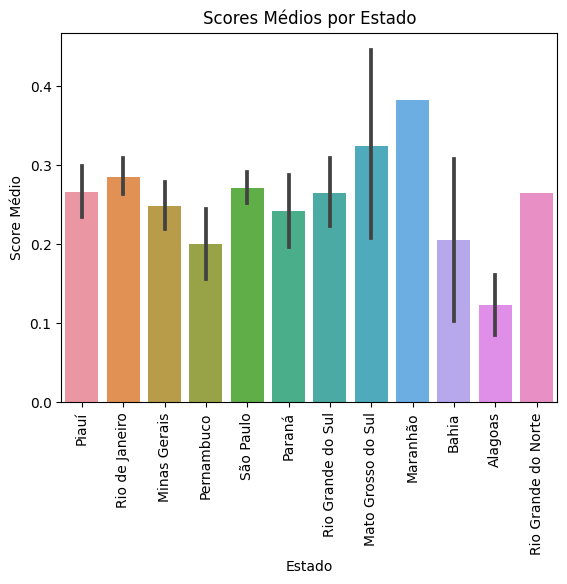

In [36]:
import seaborn as sns

# Gráfico de barras dos scores por gênero
sns.barplot(x='gender', y='scores', data=user_scores_com_postagens.merge(colab_users, on='id'))
plt.xlabel('Gênero')
plt.ylabel('Score Médio')
plt.title('Scores Médios por Gênero')
plt.show()

# Gráfico de barras dos scores por estado
sns.barplot(x='state_name', y='scores', data=user_scores_com_postagens.merge(colab_users, on='id'))
plt.xlabel('Estado')
plt.ylabel('Score Médio')
plt.title('Scores Médios por Estado')
plt.xticks(rotation='vertical')
plt.show()

In [39]:
filtered_followers = colab_followers[
    colab_followers['source'].isin(user_scores_com_postagens['id']) &
    colab_followers['target'].isin(user_scores_com_postagens['id'])
]
print(f"Total de linhas no edgelist: {colab_followers.shape[0]}")
print(f"Total de linhas filtradas:{filtered_followers.shape[0]}")
print(f"Total de usuários identificados: {user_scores_com_postagens.shape[0]}")

Total de linhas no edgelist: 160052
Total de linhas filtradas:298
Total de usuários identificados: 781


# Métricas de Grafos sociais


O código apresentado realiza uma análise de um grafo social utilizando a biblioteca NetworkX em Python. A análise é baseada em um conjunto de dados de conexões entre usuários, representados por um grafo direcionado.

Inicialmente, o grafo é construído a partir do conjunto de dados, utilizando a função `nx.from_pandas_edgelist()`, que recebe como parâmetros o dataframe contendo as conexões e as colunas que representam a origem e o destino dessas conexões.

Em seguida, são calculadas diversas métricas de rede social. A métrica "Número de Conexões" corresponde ao total de arestas presentes no grafo, que representa as interações entre os usuários. A métrica "Número de Nós Únicos" indica a quantidade de usuários distintos presentes no grafo, considerando tanto os usuários que seguem outros usuários quanto os que são seguidos.

As métricas relacionadas aos usuários são obtidas analisando os graus de entrada e saída dos nós. O "Usuário com Mais Seguidores" é identificado encontrando-se o nó com o maior grau de entrada, ou seja, o usuário que possui o maior número de seguidores. Da mesma forma, o "Usuário que Mais Segue Outros Usuários" é determinado a partir do nó com o maior grau de saída, representando o usuário que segue o maior número de outros usuários.

Por fim, é calculada a "Média de Seguidores por Usuário", que consiste no cálculo da média dos graus de entrada de todos os nós do grafo. Essa métrica fornece uma medida do engajamento médio dos usuários na rede.

Essas métricas são importantes na análise de grafos sociais, pois fornecem insights sobre a estrutura e o comportamento dos usuários na rede. Elas permitem identificar usuários influentes, entender a hierarquia e os padrões de interação entre os usuários, bem como avaliar o grau médio de influência dos usuários na rede.

Essa análise de rede social é fundamental para compreender a dinâmica e as características de uma comunidade online, identificar líderes de opinião, avaliar a disseminação de informações e auxiliar em estratégias de marketing e tomada de decisões baseadas em dados.

In [40]:
import networkx as nx

# Criar o grafo direcionado a partir do dataframe filtered_followers
graph = nx.from_pandas_edgelist(filtered_followers, 'source', 'target', create_using=nx.DiGraph)

# Calcular o número de conexões presentes no dataset
num_connections = graph.number_of_edges()

# Contar o número de nós únicos no grafo
num_nodes = graph.number_of_nodes()

# Encontrar o usuário com mais seguidores (nós de entrada)
user_followers = dict(graph.in_degree())
user_with_most_followers = max(user_followers, key=user_followers.get)
num_followers = user_followers[user_with_most_followers]

# Encontrar o usuário que mais segue outros usuários (nós de saída)
user_following = dict(graph.out_degree())
user_with_most_following = max(user_following, key=user_following.get)
num_following = user_following[user_with_most_following]

# Calcular a média de seguidores por usuário
average_followers = sum(user_followers.values()) / len(user_followers)

# Imprimir os resultados
print("Número de nós únicos no grafo:", num_nodes)
print("Número de conexões:", num_connections)
print("Usuário com mais seguidores:", user_with_most_followers)
print("Número de seguidores do usuário com mais seguidores:", num_followers)
print("Usuário que mais segue outros usuários:", user_with_most_following)
print("Número de usuários seguidos pelo usuário que mais segue outros usuários:", num_following)
print("Seguidores em média por usuário:", average_followers)


Número de nós únicos no grafo: 164
Número de conexões: 298
Usuário com mais seguidores: 313537
Número de seguidores do usuário com mais seguidores: 16
Usuário que mais segue outros usuários: 313537
Número de usuários seguidos pelo usuário que mais segue outros usuários: 21
Seguidores em média por usuário: 1.8170731707317074


# Network Plot

In [45]:
from bokeh.models import Plot, Range1d, MultiLine, Circle, HoverTool
def plot_network(filtered_followers):
    # Cria o objeto Graph do networkx e adiciona as arestas
    graph = nx.Graph()
    graph.add_edges_from(zip(filtered_followers['source'], filtered_followers['target']))

    # Cria o objeto Plot do bokeh e ajusta as configurações
    plot = Plot(width =800, height =600, x_range=Range1d(-1.1, 1.1), y_range=Range1d(-1.1, 1.1))
    plot.title.text = "Rede de Seguidores"
    plot.add_tools(HoverTool(tooltips=None))

    # Converte o objeto Graph para o formato suportado pelo bokeh
    graph_renderer = from_networkx(graph, nx.spring_layout, scale=1, center=(0, 0))

    # Adiciona os elementos gráficos ao Plot
    plot.renderers.append(graph_renderer)

    node_hover_tool = HoverTool(tooltips=[("ID", "@index")])
    plot.add_tools(node_hover_tool)

    # Exibe o gráfico
    output_notebook()
    show(plot)
#
plot_network(filtered_followers)

# Bokeh Plot

O código em questão implementa a visualização de uma rede social utilizando a biblioteca NetworkX e o pacote de visualização interativa Bokeh. Ele visa fornecer uma representação gráfica da estrutura e das comunidades presentes em uma rede social.

A função normalize é responsável por normalizar um conjunto de valores com base em limites desejados. Isso é útil para garantir que os valores estejam em uma escala adequada para visualização.

A função get_adjusted_node_size calcula o tamanho dos nós na rede com base em suas métricas de grau e centralidade. Os tamanhos são ajustados para garantir que os nós com graus muito pequenos ainda sejam visíveis na visualização. Além disso, atributos de grau e centralidade são adicionados aos nós para fins de análise.

A função plot_bokeh_network cria um gráfico interativo utilizando o Bokeh. Ela remove nós com poucas conexões para simplificar a visualização e, em seguida, define atributos de classe de modularidade e cor para cada nó com base nas comunidades identificadas na rede. Os nós são renderizados como círculos de tamanho ajustado de acordo com os atributos de tamanho do nó. A cor dos nós é determinada pelo atributo de classe de modularidade. Os atributos de grau, centralidade e classe de modularidade são exibidos como dicas de ferramentas interativas quando o cursor é colocado sobre um nó.

Em seguida, o código cria um objeto de grafo a partir dos dados fornecidos, adiciona atributos de grau aos nós e ajusta o tamanho dos nós com base nesses graus. Em seguida, são definidos atributos de tamanho e cor para os nós com base nos atributos de tamanho ajustado. O título do gráfico e as informações de dicas de ferramentas também são definidos. Finalmente, o gráfico é renderizado e exibido usando a função show do Bokeh.

No geral, o código permite a visualização interativa de uma rede social, destacando as comunidades presentes e fornecendo informações sobre os nós por meio de dicas de ferramentas interativas. Ele utiliza técnicas de escalonamento de tamanho de nó e colorização para melhorar a visualização da rede e a compreensão das informações.

In [46]:
def normalize(values, bounds):
    return [bounds['desired']['lower'] + (x - bounds['actual']['lower']) * (bounds['desired']['upper'] - bounds['desired']['lower']) / (bounds['actual']['upper'] - bounds['actual']['lower']) for x in values]

def get_adjusted_node_size(graph_network):
    degrees = nx.degree(graph_network)
    nx.set_node_attributes(graph_network, name='degree', values=dict(degrees))

    centrality = nx.eigenvector_centrality_numpy(graph_network)
    nx.set_node_attributes(graph_network, name='centrality', values=centrality)

    centrality_values = list(centrality.values())
    degree_values = [degree for node, degree in degrees]

    max_centrality = max(centrality_values)
    min_centrality = min(centrality_values)
    max_degree = max(degree_values)

    centrality_values = normalize(centrality_values, {'actual': {'lower': min_centrality, 'upper': max_centrality*2}, 'desired': {'lower': 5, 'upper': 100}})

    sizes = {node: centrality_values[i] for i, (node, _) in enumerate(degrees)}

    adjusted_node_size = {node: sizes[node] for node, _ in degrees}
    nx.set_node_attributes(graph_network, name='adjusted_node_size', values=adjusted_node_size)

def plot_bokeh_network(graph_network, network_communities, title, palette):
    get_adjusted_node_size(graph_network)

    modularity_class = {}
    modularity_color = {}

    for community_number, community in enumerate(network_communities):
        for name in community:
            modularity_class[name] = community_number
            modularity_color[name] = palette[community_number % len(palette)]

    nx.set_node_attributes(graph_network, modularity_class, 'modularity_class')
    nx.set_node_attributes(graph_network, modularity_color, 'modularity_color')

    size_by_this_attribute = 'adjusted_node_size'
    color_by_this_attribute = 'modularity_color'

    color_palette = Blues8
    node_highlight_color = 'white'
    edge_highlight_color = 'black'

    HOVER_TOOLTIPS = [
        ("user_id", "@index"),
        ("Degree", "@degree"),
        ("Centrality", "@centrality"),
        ("Modularity Class", "@modularity_class"),
        ("Modularity Color", "$color[swatch]:modularity_color"),
    ]

    plot = figure(tooltips=HOVER_TOOLTIPS, sizing_mode="stretch_width", tools="pan,wheel_zoom,save,reset", active_scroll='wheel_zoom', height=600, title=title)

    layout = nx.nx_pydot.graphviz_layout(graph_network, prog="neato")

    network_graph = from_networkx(graph_network, layout, scale=10)

    network_graph.node_renderer.glyph = Circle(size=size_by_this_attribute, fill_color=color_by_this_attribute)
    network_graph.node_renderer.hover_glyph = Circle(size=size_by_this_attribute, fill_color=node_highlight_color, line_width=2)
    network_graph.node_renderer.selection_glyph = Circle(size=size_by_this_attribute, fill_color=node_highlight_color, line_width=2)

    network_graph.edge_renderer.glyph = MultiLine(line_alpha=0.3, line_width=0.5)
    network_graph.edge_renderer.selection_glyph = MultiLine(line_color=edge_highlight_color, line_width=2)
    network_graph.edge_renderer.hover_glyph = MultiLine(line_color=edge_highlight_color, line_width=2)

    network_graph.selection_policy = NodesAndLinkedEdges()
    network_graph.inspection_policy = NodesAndLinkedEdges()

    plot.renderers.append(network_graph)

    show(plot)
#

# Score Plot

In [48]:
copied_users_scores = users_scores.merge(user_scores_com_postagens[['id', 'total_postagens']], left_on='colab_user_id', right_on='id')
copied_users_scores = copied_users_scores.rename(columns={'id': 'colab_user_id'})
copied_users_scores = copied_users_scores.set_index('colab_user_id')


print(copied_users_scores)

                 scores  total_postagens
colab_user_id                           
219046.0       0.211152                2
43341.0        0.205052                7
122640.0       0.264802                1
160035.0       0.209818                2
325627.0       0.336923                1
...                 ...              ...
345078.0       0.061679                1
214770.0       0.061609                1
172012.0       0.635814                1
301900.0       0.061609                1
151137.0       0.046523                1

[781 rows x 2 columns]


In [67]:
def get_adjusted_node_size_for_scores(graph_network, user_scores):
    degrees = dict(nx.degree(graph_network))
    nx.set_node_attributes(graph_network, name='degree', values=degrees)

    centrality = nx.eigenvector_centrality_numpy(graph_network)
    nx.set_node_attributes(graph_network, name='centrality', values=centrality)

    centrality_values = [centrality[node] for node in centrality]
    max_centrality = max(centrality_values)
    min_centrality = min(centrality_values)

    scores = user_scores['scores'].to_dict()
    total_postagens = user_scores['total_postagens'].to_dict()
    nx.set_node_attributes(graph_network, scores, name='scores')
    nx.set_node_attributes(graph_network, total_postagens, name='total_postagens')

    size_values = normalize(centrality_values, {'actual': {'lower': min_centrality, 'upper': max_centrality*2}, 'desired': {'lower': 5, 'upper': 100}})
    sizes = {node: size_values[i] for i, (node, _) in enumerate(degrees.items())}
    adjusted_node_size = {node: sizes[node] for node in degrees}
    nx.set_node_attributes(graph_network, name='adjusted_node_size', values=adjusted_node_size)
##
def plot_bokeh_network_scores(graph_network, user_scores, network_communities, title, palette):
    get_adjusted_node_size_for_scores(graph_network, user_scores)

    modularity_class = {}
    modularity_color = {}
    scores = {}

    for community_number, community in enumerate(network_communities):
        for name in community:
            modularity_class[name] = community_number
            modularity_color[name] = palette[community_number % len(palette)]

    nx.set_node_attributes(graph_network, modularity_class, 'modularity_class')
    nx.set_node_attributes(graph_network, modularity_color, 'modularity_color')

    size_by_this_attribute = 'adjusted_node_size'
    color_by_this_attribute = 'modularity_color'

    color_palette = palette

    node_highlight_color = 'white'
    edge_highlight_color = 'black'

    HOVER_TOOLTIPS = [
        ("user_id", "@index"),
        ("Degree", "@degree"),
        ("Centrality", "@centrality"),
        ("Score", "@scores"),
        ("Events Created", "@total_postagens"),
        ("Modularity Class", "@modularity_class"),
        ("Modularity Color", "$color[swatch]:modularity_color"),
    ]

    plot = figure(tooltips=HOVER_TOOLTIPS,
                  sizing_mode="stretch_width",
                  tools="pan,wheel_zoom,save,reset", active_scroll='wheel_zoom', height=600, title=title)

    layout = nx.nx_pydot.graphviz_layout(graph_network, prog="neato")

    network_graph = from_networkx(graph_network, layout, scale=25, k=len(graph_network.nodes()) * 1 / np.sqrt(len(graph_network.nodes())), center=(0, 0))

    network_graph.node_renderer.glyph = Circle(size=size_by_this_attribute, fill_color=color_by_this_attribute)
    network_graph.node_renderer.hover_glyph = Circle(size=size_by_this_attribute, fill_color=node_highlight_color, line_width=2)
    network_graph.node_renderer.selection_glyph = Circle(size=size_by_this_attribute, fill_color=node_highlight_color, line_width=2)

    network_graph.edge_renderer.glyph = MultiLine(line_alpha=0.3, line_width=0.5)
    network_graph.edge_renderer.selection_glyph = MultiLine(line_color=edge_highlight_color, line_width=2)
    network_graph.edge_renderer.hover_glyph = MultiLine(line_color=edge_highlight_color, line_width=2)

    network_graph.selection_policy = NodesAndLinkedEdges()
    network_graph.inspection_policy = NodesAndLinkedEdges()

    plot.renderers.append(network_graph)
    num_nodes_plot = len(network_graph.node_renderer.data_source.data['index'])
    print("Número de nós no plot:", num_nodes_plot)

    show(plot)
##

def create_graph(data_source, filter_graph=False, min_size=3):
  """
  Creates a graph from a pandas DataFrame of edges.

  Parameters:
  -----------
  data_source : pandas.DataFrame
      DataFrame containing the edges of the graph. Must have two columns named 'source' and 'target' with the IDs of
      the nodes connected by each edge.
  filter_graph : bool, default False
      If True, isolated nodes and small components (size less than min_size) are removed from the graph.
  min_size : int, default 3
      The minimum size for components to be kept in the graph when filter_graph is True.

  Returns:
  --------
  graph : networkx.Graph
      The resulting graph.
  """
  # Create the graph
  graph = nx.from_pandas_edgelist(data_source, 'source', 'target')

  if filter_graph:
      # Find the isolated nodes
      isolated_nodes = list(nx.isolates(graph))

      # Remove the isolated nodes from the graph
      graph.remove_nodes_from(isolated_nodes)

      # Get the connected components
      components = nx.connected_components(graph)

      # Create a list to hold the nodes to remove
      nodes_to_remove = []

      # Loop over the components and add the small ones to the list
      for component in components:
          if len(component) < min_size:
              nodes_to_remove.extend(component)

      # Remove the nodes from the graph
      graph.remove_nodes_from(nodes_to_remove)

  return graph
##
graph = create_graph(filtered_followers, filter_graph=False, min_size=4)
network_communities = community.greedy_modularity_communities(graph)
plot_bokeh_network_scores(graph, copied_users_scores, network_communities, 'Network', Blues8)

<ipython-input-67-ab57958b20a6>:59: DeprecationWarning: nx.nx_pydot.graphviz_layout depends on the pydot package, which hasknown issues and is not actively maintained. Consider usingnx.nx_agraph.graphviz_layout instead.

See https://github.com/networkx/networkx/issues/5723
  layout = nx.nx_pydot.graphviz_layout(graph_network, prog="neato")


Número de nós no plot: 164


# Echo Chambers detection

A classe `EchoChamberDetector` é uma implementação de um detector de echo chambers em uma rede social. Uma echo chamber é um fenômeno no qual um grupo de indivíduos interage e compartilha informações apenas dentro do grupo, reforçando suas próprias crenças e perspectivas, limitando a exposição a opiniões divergentes.

Para utilizar a classe, é necessário fornecer dataframes contendo os nós e as arestas do grafo. O grafo é construído utilizando a biblioteca NetworkX, e a classe oferece métodos para detectar echo chambers usando os algoritmos de partição de comunidades SpectralClustering e Louvain.

Principais Métodos:

*   `louvain_partition()`: Aplica o algoritmo de detecção de comunidades Louvain ao grafo e retorna a partição resultante.
    
*   `spectral_partition(n_clusters)`: Realiza o particionamento espectral do grafo usando a matriz de adjacência e retorna a partição resultante.
    
*   `louvain_score()`: Calcula o score de modularidade da partição obtida pelo algoritmo de Louvain.
    
*   `spectral_score(n_clusters)`: Calcula o score de modularidade da partição obtida pelo particionamento espectral.
    
*   `get_eigenvector_top_users(n)`: Retorna os n principais usuários com a maior pontuação de centralidade de autovetor no grafo. A centralidade de autovetor mede a influência de um nó em uma rede, levando em consideração a centralidade dos seus nós vizinhos.
    
*   `detect_echo_chambers(method, community_density, min_community_size, n_clusters)`: Detecta echo chambers na rede. Os parâmetros controlam o método de particionamento, a densidade mínima da comunidade, o tamanho mínimo da comunidade e o número de clusters para o particionamento espectral.
    
*   `is_echo_chamber(community)`: Determina se uma comunidade dada é uma echo chamber com base na densidade da comunidade.
    
*   `identify_echo_chambers(method, community_density, community_size, n_clusters)`: Identifica as echo chambers na rede usando o método de detecção de comunidades especificado.
    

Essa classe fornece uma abordagem modular para detectar e identificar echo chambers em redes sociais, permitindo que o usuário escolha entre diferentes métodos de particionamento e ajuste os parâmetros de detecção de acordo com suas necessidades. Isso ajuda a entender a estrutura das comunidades na rede e identificar grupos isolados que podem estar propensos à polarização e falta de diversidade de opiniões.

A importância dessas métricas e métodos reside na compreensão e análise das dinâmicas sociais nas redes online. A detecção de echo chambers é crucial para identificar como a informação se espalha em uma rede, como as interações sociais influenciam as crenças individuais e como as opiniões podem se tornar polarizadas. Essas análises podem ser aplicadas em várias áreas, como ciências sociais, análise de redes sociais, psicologia e comunicação, fornecendo insights sobre os efeitos das câmaras de eco nas interações sociais e na formação de opinião.

In [50]:
import community.community_louvain as community_louvain
import networkx as nx
import numpy as np

class SimpleEchoChamberDetector:
    def __init__(self, nodes_df, edges_df, min_community_density=0.5, min_community_size=3):
        self.nodes = nodes_df
        self.edges = edges_df
        self.G = nx.from_pandas_edgelist(self.edges, 'source', 'target')
        self.min_community_density = min_community_density
        self.min_community_size = min_community_size

    def get_eigenvector_top_users(self, n):
        """
        Returns the top n users with the highest eigenvector centrality score in the network.

        Eigenvector centrality measures the influence of a node in a network, taking into account the centrality of its
        neighboring nodes. A node with a high eigenvector centrality score indicates that it is connected to other
        well-connected nodes, making it influential in the network.

        Args:
        - n (int): The number of top users to return.

        Returns:
        - top_users (numpy.ndarray): A 1D numpy array of the IDs of the top n users with the highest eigenvector
        centrality score in the network.
        """
        centrality = nx.eigenvector_centrality_numpy(self.G)
        sorted_centrality = sorted(centrality.items(), key=lambda x: x[1], reverse=True)
        top_users = np.array([u[0] for u in sorted_centrality[:n]])
        return top_users
    ##

    def louvain_communities(self):
        partitions = community_louvain.best_partition(self.G)
        values = set(partitions.values())
        communities = [set([key for key in partitions.keys() if partitions[key] == val]) for val in values]
        return communities

    def girvan_newman_communities(self):
        def find_best_edge(G0):
            """
            Function to find the edge with the highest betweenness centrality.
            """
            edge_betweenness = nx.edge_betweenness_centrality(G0)
            sorted_edge_betweenness = sorted(edge_betweenness.items(), key=lambda x: x[1], reverse=True)
            return sorted_edge_betweenness[0][0]

        def girvan_newman_step(G):
            """
            Function to perform one step of the Girvan-Newman algorithm.
            """
            if len(G.edges) == 0:
                return []

            initial_components = nx.number_connected_components(G)
            edge_to_remove = find_best_edge(G)
            G.remove_edge(*edge_to_remove)
            new_components = nx.number_connected_components(G)

            if new_components > initial_components:
                return [c for c in nx.connected_components(G)]
            else:
                return girvan_newman_step(G)

        communities = girvan_newman_step(self.G)
        return communities

    def is_echo_chamber(self, community):
        if len(community) < self.min_community_size:
            return False

        edges = [(n1, n2) for n1 in community for n2 in community if n1 != n2 and self.G.has_edge(n1, n2)]
        density = len(edges) / (len(community) * (len(community) - 1))
        print(f"Density of community {community}: {density}")
        return density >= self.min_community_density

    def identify_echo_chambers(self, method='louvain', community_density=0.5, community_size=3):
        if method == 'louvain':
            communities = self.louvain_communities()
        elif method == 'girvan_newman':
            communities = self.girvan_newman_communities()
        else:
            raise ValueError(f"Invalid method '{method}' specified. Please choose 'louvain' or 'girvan_newman'.")

        echo_chambers = []
        print(f"The {method} has identified {len(communities)} communities: {communities}")
        for community in communities:
            if self.is_echo_chamber(community):
                echo_chambers.append(community)

        if set(map(tuple, echo_chambers)) == set(map(tuple, communities)):
            print("Echo chambers and communities are the same.")
        else:
            print("Echo chambers and communities are different.")

        return echo_chambers


# Teste de identificacao de echo chambers

Neste estudo, realizamos experimentos para analisar a detecção de comunidades em um grafo fictício utilizando dois algoritmos populares: Louvain e Girvan-Newman. Nosso objetivo era investigar como esses algoritmos identificam comunidades e, em particular, se eles seriam capazes de identificar duas câmaras de eco previamente conhecidas.

Para os experimentos, geramos aleatoriamente um grafo fictício, representando uma rede social hipotética. Em seguida, aplicamos o algoritmo Louvain e o algoritmo Girvan-Newman para detectar comunidades nessa rede.

Os resultados obtidos revelaram algumas diferenças interessantes entre os algoritmos. O algoritmo Louvain identificou um maior número de comunidades em comparação com o Girvan-Newman. Em contraste, ambos os algoritmos identificaram as mesmas duas câmaras de eco que eram esperadas.

Essas discrepâncias no número de comunidades podem ser explicadas pelas diferentes abordagens adotadas por cada algoritmo. O Louvain é um método baseado em otimização que busca maximizar a modularidade global da rede. Portanto, ele pode identificar partições mais granulares, permitindo que nós individuais formem suas próprias comunidades se isso aumentar a modularidade global. Por outro lado, o Girvan-Newman é um algoritmo de eliminação de arestas que divide a rede em comunidades menores por meio da remoção iterativa das arestas mais importantes. O número de comunidades resultantes depende do critério de remoção de arestas adotado.

Esses resultados têm implicações importantes para a análise de redes sociais e detecção de comunidades. O algoritmo Louvain, com sua capacidade de identificar comunidades mais granulares, pode ser útil para identificar grupos menores e mais específicos dentro de uma rede. Por outro lado, o algoritmo Girvan-Newman é eficaz na identificação de comunidades mais amplas, especialmente quando o objetivo é identificar câmaras de eco ou grupos polarizados.

O código desenvolvido para este estudo pode ser útil em uma variedade de casos de uso. Ele pode ser aplicado na análise de redes sociais reais, permitindo a detecção de comunidades e a compreensão das estruturas subjacentes. Além disso, o código pode ser adaptado e utilizado em estudos de outras áreas, como análise de redes biológicas ou redes de colaboração científica.

Em resumo, os experimentos demonstraram que o algoritmo Louvain e o algoritmo Girvan-Newman são capazes de identificar as câmaras de eco desejadas em um grafo fictício, embora com diferenças no número de comunidades detectadas. Esses resultados destacam a importância de selecionar o algoritmo adequado com base nos objetivos específicos da análise de redes sociais e fornecem insights valiosos para o campo da detecção de comunidades em redes complexas.

In [51]:
import uuid
import random
##
# Crie um grafo vazio
G = nx.Graph()
# Adicione alguns nós altamente conectados
echo_chamber_1 = [str(uuid.uuid4()) for _ in range(8)]
G.add_edges_from([(n1, n2) for n1 in echo_chamber_1 for n2 in echo_chamber_1 if n1 != n2])
# Adicione outra câmara de eco
echo_chamber_2 = [str(uuid.uuid4()) for _ in range(5)]
G.add_edges_from([(n1, n2) for n1 in echo_chamber_2 for n2 in echo_chamber_2 if n1 != n2])
# Adicione alguns nós que não estão em câmaras de eco
non_echo_nodes = [str(uuid.uuid4()) for _ in range(8)]
for i in range(len(non_echo_nodes) - 1):
    G.add_edge(non_echo_nodes[i], non_echo_nodes[i+1])
# Adicione mais 30 nós que estão conectados de forma aleatória
additional_nodes = [str(uuid.uuid4()) for _ in range(50)]
for i in range(len(additional_nodes) - 1):
    G.add_edge(additional_nodes[i], additional_nodes[random.randint(0, len(additional_nodes) - 1)])
# Convert node labels to integers
    mapping = {node: i for i, node in enumerate(G.nodes())}
    G = nx.relabel_nodes(G, mapping)
##
network_communities = community.greedy_modularity_communities(G)
plot_bokeh_network(G, network_communities, 'Network', Blues8)

<ipython-input-46-1af4f5089cdf>:56: DeprecationWarning: nx.nx_pydot.graphviz_layout depends on the pydot package, which hasknown issues and is not actively maintained. Consider usingnx.nx_agraph.graphviz_layout instead.

See https://github.com/networkx/networkx/issues/5723
  layout = nx.nx_pydot.graphviz_layout(graph_network, prog="neato")


# Identificando echo chambers com algoritmo de louvain

In [52]:
# Generate random non-repeating integers for node labels
num_nodes = 8 + 5 + 8 + 50  # Total number of nodes
node_labels = random.sample(range(1, num_nodes + 1), num_nodes)

# Create an empty graph
G = nx.Graph()

# Add highly connected nodes
echo_chamber_1 = node_labels[:8]
G.add_edges_from([(n1, n2) for n1 in echo_chamber_1 for n2 in echo_chamber_1 if n1 != n2])

# Add another echo chamber
echo_chamber_2 = node_labels[8:13]
G.add_edges_from([(n1, n2) for n1 in echo_chamber_2 for n2 in echo_chamber_2 if n1 != n2])

# Add non-echo nodes
non_echo_nodes = node_labels[13:21]
for i in range(len(non_echo_nodes) - 1):
    G.add_edge(non_echo_nodes[i], non_echo_nodes[i+1])

# Add additional random nodes
additional_nodes = node_labels[21:]
for i in range(len(additional_nodes) - 1):
    G.add_edge(additional_nodes[i], additional_nodes[random.randint(0, len(additional_nodes) - 1)])
# Convert node labels to integers
mapping = {node: i for i, node in enumerate(G.nodes())}
G = nx.relabel_nodes(G, mapping)
# Create dataframes for nodes and edges
nodes_df = pd.DataFrame({'id': list(G.nodes())})
edges_df = pd.DataFrame(list(G.edges()), columns=['source', 'target'])

print(nodes_df.head())
print(edges_df.head())

# Crie uma instância da classe EchoChamberDetector
detector = SimpleEchoChamberDetector(nodes_df, edges_df)
eigenvector=detector.get_eigenvector_top_users(5)
print(f"Eigenvector Users: {eigenvector}")

# Identifique as câmaras de eco
echo_chambers = detector.identify_echo_chambers(method='louvain', community_density=0.5, community_size=5)
#echo_chambers = detector.detect_echo_chambers(method='louvain', community_density=0.5, community_size=3, n_clusters=5)
echo_chambers

   id
0   0
1   1
2   2
3   3
4   4
   source  target
0       0       1
1       0       2
2       0       3
3       0       4
4       0       5
Eigenvector Users: [1 4 2 6 3]
The louvain has identified 10 communities: [{0, 1, 2, 3, 4, 5, 6, 7}, {8, 9, 10, 11, 12}, {67, 68, 70, 46, 47, 49, 50, 57}, {13, 14, 15, 16, 17, 18, 19, 20}, {36, 69, 29, 51, 52, 21, 22, 25, 26, 28, 61, 30}, {64, 35, 40, 41, 45, 27, 60, 62, 63}, {42, 43, 44, 53, 54}, {24, 23}, {32, 37, 38, 55, 56, 58, 59, 31}, {33, 34, 66, 65, 39, 48}]
Density of community {0, 1, 2, 3, 4, 5, 6, 7}: 1.0
Density of community {8, 9, 10, 11, 12}: 1.0
Density of community {67, 68, 70, 46, 47, 49, 50, 57}: 0.25
Density of community {13, 14, 15, 16, 17, 18, 19, 20}: 0.25
Density of community {36, 69, 29, 51, 52, 21, 22, 25, 26, 28, 61, 30}: 0.16666666666666666
Density of community {64, 35, 40, 41, 45, 27, 60, 62, 63}: 0.2222222222222222
Density of community {42, 43, 44, 53, 54}: 0.4
Density of community {32, 37, 38, 55, 56, 58, 59, 31}: 

[{0, 1, 2, 3, 4, 5, 6, 7}, {8, 9, 10, 11, 12}]

# Identificando echo chambers com algoritmo de Girvan Newman

In [53]:
# Crie dataframes para os nós e arestas
nodes_df = pd.DataFrame({'id': list(G.nodes())})
edges_df = pd.DataFrame(list(G.edges()), columns=['source', 'target'])

# Crie uma instância da classe EchoChamberDetector
detector = SimpleEchoChamberDetector(nodes_df, edges_df)

# Identifique as câmaras de eco
echo_chambers = detector.identify_echo_chambers(method='girvan_newman', community_density=0.5, community_size=5)
#echo_chambers = detector.detect_echo_chambers(method='louvain', community_density=0.5, community_size=3, n_clusters=5)
echo_chambers

The girvan_newman has identified 8 communities: [{0, 1, 2, 3, 4, 5, 6, 7}, {8, 9, 10, 11, 12}, {13, 14, 15, 16, 17, 18, 19, 20}, {21, 22, 25, 26, 27, 28, 29, 30, 36, 37, 51, 52, 55, 56, 58, 61, 63, 64, 69}, {24, 23}, {32, 35, 68, 67, 70, 38, 40, 41, 45, 46, 47, 49, 50, 57, 59, 60, 62, 31}, {33, 34, 66, 65, 39, 48}, {42, 43, 44, 53, 54}]
Density of community {0, 1, 2, 3, 4, 5, 6, 7}: 1.0
Density of community {8, 9, 10, 11, 12}: 1.0
Density of community {13, 14, 15, 16, 17, 18, 19, 20}: 0.25
Density of community {21, 22, 25, 26, 27, 28, 29, 30, 36, 37, 51, 52, 55, 56, 58, 61, 63, 64, 69}: 0.10526315789473684
Density of community {32, 35, 68, 67, 70, 38, 40, 41, 45, 46, 47, 49, 50, 57, 59, 60, 62, 31}: 0.1111111111111111
Density of community {33, 34, 66, 65, 39, 48}: 0.3333333333333333
Density of community {42, 43, 44, 53, 54}: 0.4
Echo chambers and communities are different.


[{0, 1, 2, 3, 4, 5, 6, 7}, {8, 9, 10, 11, 12}]

# Incorporando Heuristicas ERGM

In [101]:
class EchoChamberDetector:
    def __init__(self, nodes_df, edges_df, scores_df, min_community_density=0.5, min_community_size=3):
        self.nodes = nodes_df
        self.edges = edges_df
        self.scores = scores_df
        self.G = nx.from_pandas_edgelist(self.edges, 'source', 'target')
        self.min_community_density = min_community_density
        self.min_community_size = min_community_size

    def calculate_homogeneity_of_opinions(self, community):
        community_scores = self.scores.loc[community, 'scores']
        homogeneity = community_scores.std()
        return homogeneity

    def get_eigenvector_top_users(self, n):
        """
        Returns the top n users with the highest eigenvector centrality score in the network.

        Eigenvector centrality measures the influence of a node in a network, taking into account the centrality of its
        neighboring nodes. A node with a high eigenvector centrality score indicates that it is connected to other
        well-connected nodes, making it influential in the network.

        Args:
        - n (int): The number of top users to return.

        Returns:
        - top_users (numpy.ndarray): A 1D numpy array of the IDs of the top n users with the highest eigenvector
        centrality score in the network.
        """
        centrality = nx.eigenvector_centrality_numpy(self.G)
        sorted_centrality = sorted(centrality.items(), key=lambda x: x[1], reverse=True)
        top_users = np.array([u[0] for u in sorted_centrality[:n]])
        return top_users

    def louvain_communities(self):
        partitions = community_louvain.best_partition(self.G)
        values = set(partitions.values())
        communities = [set([key for key in partitions.keys() if partitions[key] == val]) for val in values]
        return communities

    def girvan_newman_communities(self):
        def find_best_edge(G0):
            """
            Function to find the edge with the highest betweenness centrality.
            """
            edge_betweenness = nx.edge_betweenness_centrality(G0)
            sorted_edge_betweenness = sorted(edge_betweenness.items(), key=lambda x: x[1], reverse=True)
            return sorted_edge_betweenness[0][0]

        def girvan_newman_step(G):
            """
            Function to perform one step of the Girvan-Newman algorithm.
            """
            if len(G.edges) == 0:
                return []

            initial_components = nx.number_connected_components(G)
            edge_to_remove = find_best_edge(G)
            G.remove_edge(*edge_to_remove)
            new_components = nx.number_connected_components(G)

            if new_components > initial_components:
                return [c for c in nx.connected_components(G)]
            else:
                return girvan_newman_step(G)

        communities = girvan_newman_step(self.G)
        return communities

    def calculate_echo_chamber_probability(self, community):
        density = self.calculate_community_density(community)
        homogeneity = self.calculate_homogeneity_of_opinions(community)
        external_connections = self.calculate_external_connections(community)
        influencers = self.calculate_influencers(community)

        #print(f"density: {density} - homogeneity: {homogeneity} - external_connections: {external_connections} - influencers{influencers}")

        probability = np.exp(
            self.beta1 * density +
            self.beta2 * homogeneity +
            self.beta3 * external_connections +
            self.beta4 * influencers
        )

        return probability

    def is_echo_chamber(self, community):
        graph_probability = self.calculate_echo_chamber_probability(list(self.G.nodes))
        community_probability = self.calculate_echo_chamber_probability(community)
        print(f"graph_probability: {graph_probability} - community_probability: {community_probability}")
        return community_probability >= graph_probability

    def identify_echo_chambers(self, method='louvain', community_density=0.5, community_size=3,
                               beta1=1.0, beta2=1.0, beta3=1.0, beta4=1.0):
        self.beta1 = beta1
        self.beta2 = beta2
        self.beta3 = beta3
        self.beta4 = beta4

        if method == 'louvain':
            communities = self.louvain_communities()
        elif method == 'girvan_newman':
            communities = self.girvan_newman_communities()
        else:
            raise ValueError(f"Invalid method '{method}' specified. Please choose 'louvain' or 'girvan_newman'.")

        echo_chambers = []
        print(f"The {method} has identified {len(communities)} communities: {communities}")
        for community in communities:
          if self.is_echo_chamber(list(community)):
              echo_chambers.append(list(community))

        if set(map(tuple, echo_chambers)) == set(map(tuple, communities)):
            print("Echo chambers and communities are the same.")
        else:
            print("Echo chambers and communities are different.")

        return echo_chambers

    def calculate_community_density(self, community):
        edges = [(n1, n2) for n1 in community for n2 in community if n1 != n2 and self.G.has_edge(n1, n2)]
        density = len(edges) / (len(community) * (len(community) - 1))
        return density

    def calculate_external_connections(self, community):
      external_connections = 0
      possible_connections = 0
      for node in community:
          for neighbor in self.G.neighbors(node):
              if neighbor not in community:
                  external_connections += 1
              possible_connections += 1

      if possible_connections > 0:
          factor = external_connections / possible_connections
      else:
          factor = 0.0

      return factor

    def calculate_influencers(self, community):
      top_users = self.get_eigenvector_top_users(len(community))
      influencers = len(set(top_users).intersection(community))

      if len(community) > 0:
          factor = influencers / len(community)
      else:
          factor = 0.0

      return factor
### FIM DA CLASSE #####
##

# Gerando grafos aleatórios

In [125]:
def generate_random_graph(num_nodes, num_echo_chambers, model):
    G = nx.Graph()

    if model == "barabasi":
        G = nx.barabasi_albert_graph(num_nodes, m=2)
    elif model == "watts":
        k = 4  # average degree of the nodes
        p = 0.3  # probability of rewiring an edge
        G = nx.watts_strogatz_graph(num_nodes, k, p)
    else:
        raise ValueError("Invalid model type. Please choose either 'barabasi' or 'watts'.")

    # Generate echo chamber nodes
    echo_chamber_nodes = []
    total_echo_chamber_nodes = num_nodes // 5  # Adjust the factor as desired
    for _ in range(num_echo_chambers):
        chamber_size = random.randint(3, total_echo_chamber_nodes)
        chamber_nodes = [str(uuid.uuid4()) for _ in range(chamber_size)]
        G.add_edges_from([(n1, n2) for n1 in chamber_nodes for n2 in chamber_nodes if n1 != n2])
        echo_chamber_nodes.extend(chamber_nodes)

    # Connect echo chambers to the main graph or to other echo chambers
    for node in echo_chamber_nodes:
        if random.random() < 0.3:  # Adjust the probability as desired
            random_node = random.choice(list(G.nodes()))
            G.add_edge(node, random_node)

    # Set is_echo_chamber_node attribute to True for echo chamber nodes
    for node in G.nodes:
        G.nodes[node]['is_echo_chamber_node'] = False
    for node in echo_chamber_nodes:
        G.nodes[node]['is_echo_chamber_node'] = True

    # Convert node labels to integers
    mapping = {node: i for i, node in enumerate(G.nodes())}
    G = nx.relabel_nodes(G, mapping)

    nodes_df = pd.DataFrame({'id': list(G.nodes())})
    edges_df = pd.DataFrame(list(G.edges()), columns=['source', 'target'])
    scores_df = pd.DataFrame({'id': list(G.nodes()), 'scores': np.random.rand(len(G.nodes()))})
    scores_df.set_index('id', inplace=True)

    return G, nodes_df, edges_df, scores_df
# Example usage
num_nodes = 100
num_echo_chambers = 3
model_type = "watts"

G, nodes_df, edges_df, scores_df = generate_random_graph(num_nodes, num_echo_chambers, model_type)
print(nodes_df.head(1))
print(scores_df.head(1))

   id
0   0
      scores
id          
0   0.294858


# Destacando camaras de eco

In [161]:
def adjust_node_size_for_echo_chambers(graph_network):
    # Define um tamanho fixo para todos os nós
    fixed_size = 10

    # Cria um dicionário com o tamanho fixo para cada nó
    sizes = {node: fixed_size for node in graph_network.nodes()}

    # Define os tamanhos dos nós no grafo
    nx.set_node_attributes(graph_network, name='adjusted_node_size', values=sizes)
##
def plot_bokeh_echo_chamber(graph_network, network_communities, title, layout_type='spring'):
    adjust_node_size_for_echo_chambers(graph_network)
    modularity_class = {}
    modularity_color = {}
    palette = Category20[10]

    for community_number, community in enumerate(network_communities):
        for name in community:
            modularity_class[name] = community_number
            modularity_color[name] = palette[community_number % len(palette)]

    nx.set_node_attributes(graph_network, modularity_class, 'modularity_class')
    nx.set_node_attributes(graph_network, modularity_color, 'modularity_color')

    size_by_this_attribute = 'adjusted_node_size'
    color_by_this_attribute = 'modularity_color'

    node_highlight_color = 'white'
    edge_highlight_color = 'black'

    HOVER_TOOLTIPS = [
        ("user_id", "@index"),
        ("Degree", "@degree"),
        ("Centrality", "@centrality"),
        ("In Echo Chamber", "@is_echo_chamber_node"),
        ("Modularity Class", "@modularity_class"),
        ("Modularity Color", "$color[swatch]:modularity_color"),
    ]

    plot = figure(tooltips=HOVER_TOOLTIPS, sizing_mode="stretch_width", tools="pan,wheel_zoom,save,reset", active_scroll='wheel_zoom', height=600, title=title)

    if layout_type == 'spring':
        layout = nx.spring_layout(graph_network, seed=42)
    elif layout_type == 'kamada_kawai':
        layout = nx.kamada_kawai_layout(graph_network)
    elif layout_type == 'circular':
        layout = nx.circular_layout(graph_network)
    elif layout_type == 'neato':
        layout = nx.nx_pydot.graphviz_layout(graph_network, prog="neato")
    elif layout_type == 'spectral':
        layout = nx.spectral_layout(graph_network)
    elif layout_type == 'dot':
        layout = nx.nx_pydot.graphviz_layout(graph_network, prog="dot")
    elif layout_type == 'sfdp':
        layout = nx.nx_pydot.graphviz_layout(graph_network, prog="sfdp")

    network_graph = from_networkx(graph_network, layout, scale=10)

    network_graph.node_renderer.glyph = Circle(size=size_by_this_attribute, fill_color={'field': color_by_this_attribute})
    network_graph.node_renderer.hover_glyph = Circle(size=size_by_this_attribute, fill_color=node_highlight_color, line_width=2)
    network_graph.node_renderer.selection_glyph = Circle(size=size_by_this_attribute, fill_color=node_highlight_color, line_width=2)

    network_graph.edge_renderer.glyph = MultiLine(line_alpha=0.5, line_width=0.5)
    network_graph.edge_renderer.selection_glyph = MultiLine(line_color=edge_highlight_color, line_width=2)
    network_graph.edge_renderer.hover_glyph = MultiLine(line_color=edge_highlight_color, line_width=2)

    network_graph.selection_policy = NodesAndLinkedEdges()
    network_graph.inspection_policy = NodesAndLinkedEdges()

    main_hub_color = "white"

    network_graph.node_renderer.data_source.data['modularity_color'] = [modularity_color.get(node, main_hub_color) for node in graph_network.nodes()]
    network_graph.node_renderer.data_source.data['modularity_color'] = [color if graph_network.nodes[node].get('is_echo_chamber_node', False) else main_hub_color for node, color in zip(graph_network.nodes(), network_graph.node_renderer.data_source.data['modularity_color'])]


    plot.renderers.append(network_graph)

    show(plot)
##

network_communities = list(nx.algorithms.community.greedy_modularity_communities(G))
plot_bokeh_echo_chamber(G, network_communities, 'Network', "kamada_kawai")


# Exercício em OOP

In [230]:
class EchoChamberVisualizer:
  def __init__(self, graph_network, centrality_strategy, layout_strategy):
      self.graph_network = graph_network
      self.centrality_strategy = centrality_strategy
      self.layout_strategy = layout_strategy

  def plot(self, network_communities, title, plot_type=EchoChamberVisualizer.PlotType.BOKEH, options=None):
        self.adjust_node_size_for_echo_chambers()
        modularity_class = {}
        modularity_color = {}
        palette = Category20[10]

        for community_number, community in enumerate(network_communities):
            for name in community:
                modularity_class[name] = community_number
                modularity_color[name] = palette[community_number % len(palette)]

        nx.set_node_attributes(self.graph_network, modularity_class, 'modularity_class')
        nx.set_node_attributes(self.graph_network, modularity_color, 'modularity_color')

        if options is None:
            options = {}

        layout = self.layout_strategy.configure_layout(self.graph_network)
        options['modularity_class'] = modularity_class
        options['modularity_color'] = modularity_color

        plot = EchoChamberVisualizer.GraphPlotFactory.create_plot(plot_type, layout, options)
        plot.plot(self.graph_network)

  class PlotType(Enum):
      BOKEH = "bokeh"
      MATPLOTLIB = "matplotlib"

  class BokehPlot:
      def __init__(self, options, layout):
          self.options = options
          self.layout = layout

      def plot(self, graph_network):
          modularity_class = {}
          modularity_color = {}

          if 'modularity_class' in self.options:
            modularity_class = self.options['modularity_class']
            del self.options['modularity_class']

          if 'modularity_color' in self.options:
            modularity_color = self.options['modularity_color']
            del self.options['modularity_color']

          tooltips = self.options.get('tooltips', [])
          if 'tools' not in self.options:
              self.options['tools'] = []
          hover_tool = HoverTool(tooltips=tooltips)
          self.options['tools'].append(hover_tool)
          plot = figure(**self.options)
          size_by_this_attribute = 'adjusted_node_size'
          color_by_this_attribute = 'modularity_color'

          node_highlight_color = 'white'
          edge_highlight_color = 'black'
          network_graph = from_networkx(graph_network, self.layout, scale=10)

          network_graph.node_renderer.glyph = Circle(size=size_by_this_attribute, fill_color={'field': color_by_this_attribute})
          network_graph.node_renderer.hover_glyph = Circle(size=size_by_this_attribute, fill_color=node_highlight_color, line_width=2)
          network_graph.node_renderer.selection_glyph = Circle(size=size_by_this_attribute, fill_color=node_highlight_color, line_width=2)

          network_graph.edge_renderer.glyph = MultiLine(line_alpha=0.5, line_width=0.5)
          network_graph.edge_renderer.selection_glyph = MultiLine(line_color=edge_highlight_color, line_width=2)
          network_graph.edge_renderer.hover_glyph = MultiLine(line_color=edge_highlight_color, line_width=2)

          network_graph.selection_policy = NodesAndLinkedEdges()
          network_graph.inspection_policy = NodesAndLinkedEdges()

          main_hub_color = "white"

          network_graph.node_renderer.data_source.data['modularity_color'] = [modularity_color.get(node, main_hub_color) for node in graph_network.nodes()]
          network_graph.node_renderer.data_source.data['modularity_color'] = [color if graph_network.nodes[node].get('is_echo_chamber_node', False) else main_hub_color for node, color in zip(graph_network.nodes(), network_graph.node_renderer.data_source.data['modularity_color'])]

          plot.renderers.append(network_graph)
          show(plot)

  class MatPlot:
    def __init__(self, options, layout):
        self.options = options
        self.layout = layout

    def plot(self, graph_network):
        modularity_class = {}
        modularity_color = {}

        if 'modularity_class' in self.options:
            modularity_class = self.options['modularity_class']
            del self.options['modularity_class']

        if 'modularity_color' in self.options:
            del self.options['modularity_color']

        if 'node_color' in self.options:
            del self.options['node_color']

        main_hub_color = "#FFFFFF"
        node_colors = [modularity_color.get(node, main_hub_color) for node in graph_network.nodes()]
        node_colors = [modularity_class.get(node, -1) if graph_network.nodes[node].get('is_echo_chamber_node', False) else main_hub_color for node in graph_network.nodes()]

        node_sizes = [graph_network.nodes[node]['adjusted_node_size'] for node in graph_network.nodes()]

        plt.figure()

        unique_colors = np.unique(node_colors)
        color_palette = plt.get_cmap('tab20', len(unique_colors))
        color_dict = {color: color_palette(idx) for idx, color in enumerate(unique_colors)}
        node_colors_mapped = [color_dict[color] if color in color_dict else main_hub_color for color in node_colors]

        nx.draw_networkx(
            graph_network,
            pos=self.layout,
            arrows=True,
            node_size=node_sizes,
            node_color=node_colors_mapped,
            **self.options
        )
        plt.show()

  class GraphPlotFactory:
      @staticmethod
      def create_plot(plot_type, layout, options):
          if plot_type == EchoChamberVisualizer.PlotType.BOKEH:
              return EchoChamberVisualizer.BokehPlot(options, layout)
          elif plot_type == EchoChamberVisualizer.PlotType.MATPLOTLIB:
              return EchoChamberVisualizer.MatPlot(options, layout)
          else:
              raise ValueError("Invalid plot type")

  class CentralityStrategy(ABC):
      def __init__(self, min_size, max_size):
          self.min_size = min_size
          self.max_size = max_size

      @abstractmethod
      def compute(self, graph_network):
          pass

      def _normalize_centrality(self, centrality):
          min_centrality = min(centrality.values())
          max_centrality = max(centrality.values())
          sizes = {}
          for node, centrality in centrality.items():
              normalized_centrality = (centrality - min_centrality) / (max_centrality - min_centrality)
              size = self.min_size + normalized_centrality * (self.max_size - self.min_size)
              sizes[node] = size
          return sizes

  class DegreeCentralityStrategy(CentralityStrategy):
      def compute(self, graph_network):
          centrality = nx.degree_centrality(graph_network)
          return self._normalize_centrality(centrality)

  class ClosenessCentralityStrategy(CentralityStrategy):
      def compute(self, graph_network):
          centrality = nx.closeness_centrality(graph_network)
          return self._normalize_centrality(centrality)

  class BetweennessCentralityStrategy(CentralityStrategy):
      def compute(self, graph_network):
          centrality = nx.betweenness_centrality(graph_network)
          return self._normalize_centrality(centrality)

  class EigenvectorCentralityStrategy(CentralityStrategy):
      def compute(self, graph_network):
          centrality = nx.eigenvector_centrality(graph_network, max_iter=500)
          return self._normalize_centrality(centrality)

  def adjust_node_size_for_echo_chambers(self):
      sizes = self.centrality_strategy.compute(self.graph_network)
      nx.set_node_attributes(self.graph_network, name='adjusted_node_size', values=sizes)

  class LayoutStrategy(ABC):
      @abstractmethod
      def configure_layout(self, graph_network):
          pass

  class SpringLayoutStrategy(LayoutStrategy):
    def configure_layout(self, graph_network):
        return nx.spring_layout(graph_network, seed=42)

  class KamadaKawaiLayoutStrategy(LayoutStrategy):
      def configure_layout(self, graph_network):
          return nx.kamada_kawai_layout(graph_network)

  class CircularLayoutStrategy(LayoutStrategy):
      def configure_layout(self, graph_network):
          return nx.circular_layout(graph_network)

  class NeatoLayoutStrategy(LayoutStrategy):
      def configure_layout(self, graph_network):
          return nx.nx_pydot.graphviz_layout(graph_network, prog="neato")

  class SpectralLayoutStrategy(LayoutStrategy):
      def configure_layout(self, graph_network):
          return nx.spectral_layout(graph_network)

  class DotLayoutStrategy(LayoutStrategy):
      def configure_layout(self, graph_network):
          return nx.nx_pydot.graphviz_layout(graph_network, prog="dot")

  class SFDPLayoutStrategy(LayoutStrategy):
      def configure_layout(self, graph_network):
          return nx.nx_pydot.graphviz_layout(graph_network, prog="sfdp")
############################################################################################

# Aplicando o modelo ERGM

In [59]:
# Crie uma instância da classe EchoChamberDetector
detector = EchoChamberDetector(nodes_df, edges_df,  scores_df)

# Set the desired parameters for identifying echo chambers
method = 'louvain'
community_density = 0.5
community_size = 3
beta1 = 1.0
beta2 = 1.0
beta3 = 1.0
beta4 = 1.0

# Identify the echo chambers using the specified method and parameters
echo_chambers = detector.identify_echo_chambers(method, community_density, community_size, beta1, beta2, beta3, beta4)

# Print the identified echo chambers
for i, chamber in enumerate(echo_chambers):
    print(f"Echo Chamber {i+1}: {chamber}")

The louvain has identified 8 communities: [{0, 1, 6, 14, 17, 52, 53, 54, 63, 65, 66, 67, 90, 91, 92, 93, 94, 95, 96, 97, 98, 99}, {23, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50, 51}, {2, 3, 4, 18, 19, 64, 77, 78, 79, 80, 81, 82, 83, 84, 85, 86, 87, 88, 89}, {5, 7, 8, 9, 10, 11, 12, 13, 15, 16, 20, 21, 22, 24, 25, 26, 27, 28, 29, 30, 31, 32, 68, 69, 70, 71, 72, 73, 74, 75, 76}, {128, 129, 130, 131, 132, 123, 124, 125, 126, 127}, {100, 101, 102, 103, 104, 105, 106, 107, 108, 109, 110, 111, 112, 113}, {114, 115, 116, 117, 118, 119, 120, 121, 122}, {55, 56, 57, 58, 59, 60, 61, 62}]
Echo chambers and communities are different.
Echo Chamber 1: [128, 129, 130, 131, 132, 123, 124, 125, 126, 127]
Echo Chamber 2: [100, 101, 102, 103, 104, 105, 106, 107, 108, 109, 110, 111, 112, 113]
Echo Chamber 3: [114, 115, 116, 117, 118, 119, 120, 121, 122]


# Identificando echo chambers no dataset original (Girvan-Newman)

In [118]:
# Criar dataframes para os nós e arestas
nodes_df = pd.DataFrame({'id': graph.nodes()})
edges_df = pd.DataFrame(graph.edges(), columns=['source', 'target'])

# Crie uma instância da classe EchoChamberDetector
detector = EchoChamberDetector(nodes_df, edges_df,  copied_users_scores)

# Set the desired parameters for identifying echo chambers
method = 'girvan_newman'
community_density = 0.5
community_size = 5
beta1 = 1
beta2 = 0.5
beta3 = 1
beta4 = 0.2

top_users = detector.get_eigenvector_top_users(5)
print(f"Most influential users: {top_users}")

# Identify the echo chambers using the specified method and parameters
echo_chambers = detector.identify_echo_chambers(method, community_density, community_size, beta1, beta2, beta3, beta4)
# Add is_echo_chamber_node attribute to graph nodes
for node in graph.nodes():
    graph.nodes[node]['is_echo_chamber_node'] = any(node in chamber for chamber in echo_chambers)

# Print the identified echo chambers
for i, chamber in enumerate(echo_chambers):
    print(f"Echo Chamber {i+1}: {chamber}")
#
network_communities = list(nx.algorithms.community.greedy_modularity_communities(graph))
plot_bokeh_echo_chamber(graph, network_communities, 'Network', 'spring')


Most influential users: [313537 164196 155379  76184 186310]
The girvan_newman has identified 16 communities: [{3840, 5255, 323079, 224521, 199306, 118544, 169493, 228246, 402967, 76184, 126873, 326298, 64156, 156572, 162207, 139552, 160545, 162338, 166946, 77094, 38, 59559, 165161, 236585, 120107, 203817, 195502, 220770, 43696, 325041, 210354, 97592, 59960, 158967, 75328, 156353, 241090, 59843, 211140, 138183, 11464, 222795, 43341, 64336, 44626, 210902, 170584, 114778, 6622, 65247, 167264, 219870, 238047, 58847, 43620, 180581, 86500, 2404, 164196, 63974, 245217, 362475, 101739, 163695, 64112, 228722, 155379, 43126, 115575, 59001, 146043, 1021, 285695}, {237832, 217864, 278655, 40076, 26510, 456333, 304910, 221969, 265740, 275098, 214171, 230428, 124189, 210338, 215847, 332967, 230315, 209196, 277550, 222255, 198576, 148409, 346043, 131260, 58047, 313537, 257731, 345539, 236997, 186310, 222151, 328520, 45384, 273607, 301900, 166092, 278352, 291288, 319962, 219483, 117088, 212834, 23933

# Identificando echo chambers no dataset original (Louvain)

In [119]:
# Criar dataframes para os nós e arestas
nodes_df = pd.DataFrame({'id': graph.nodes()})
edges_df = pd.DataFrame(graph.edges(), columns=['source', 'target'])

# Crie uma instância da classe EchoChamberDetector
detector = EchoChamberDetector(nodes_df, edges_df,  copied_users_scores)

# Set the desired parameters for identifying echo chambers
method = 'louvain'
community_density = 0.5
community_size = 5
beta1 = 1
beta2 = 0.5
beta3 = 1
beta4 = 0.5

top_users = detector.get_eigenvector_top_users(5)
print(f"Most influential users: {top_users}")

# Identify the echo chambers using the specified method and parameters
echo_chambers = detector.identify_echo_chambers(method, community_density, community_size, beta1, beta2, beta3, beta4)
# Add is_echo_chamber_node attribute to graph nodes
for node in graph.nodes():
    graph.nodes[node]['is_echo_chamber_node'] = any(node in chamber for chamber in echo_chambers)

# Print the identified echo chambers
for i, chamber in enumerate(echo_chambers):
    print(f"Echo Chamber {i+1}: {chamber}")
#
network_communities = list(nx.algorithms.community.greedy_modularity_communities(graph))
plot_bokeh_echo_chamber(graph, network_communities, 'Network', 'spring')


Most influential users: [313537 164196 155379  76184 186310]
The louvain has identified 21 communities: [{5255, 228246, 126873, 160545, 162338, 77094, 38, 165161, 195502, 210354, 97592, 241090, 222795, 114778, 6622, 238047, 167264, 43620, 180581, 86500, 115575, 64112, 228722, 155379, 43126, 158967}, {3840, 2404, 1021, 11464}, {257731, 345539, 239331, 186310, 237832, 328520, 342893, 222255, 291288, 658425, 275098, 278655}, {1220, 1020}, {407747, 407727}, {217864, 265740, 456333, 304910, 221969, 214171, 210338, 215847, 332967, 277550, 346043, 313537, 222151, 273607, 301900, 166092, 278352, 319962, 232418, 326374, 662506, 359022, 459890, 324850, 332532, 262645, 219892, 325623, 237176, 203387, 226175}, {323079, 224521, 199306, 118544, 169493, 402967, 76184, 326298, 64156, 162207, 139552, 166946, 59559, 236585, 43696, 325041, 59960, 75328, 59843, 211140, 138183, 43341, 64336, 44626, 210902, 170584, 219870, 65247, 58847, 245217, 220770, 164196, 63974, 362475, 101739, 163695, 59001, 146043, 2

# Extra: Create a random sampling from the original dataset

In [ ]:
from IPython.display import HTML

# Defina o número de eventos a serem amostrados
sample_size = 1000

# Carregue o arquivo de eventos
events_data = pd.read_csv(events_file_path)

# Faça o sample dos eventos
sampled_events = events_data.sample(n=sample_size, random_state=42)

# Salve o sample em um novo arquivo CSV
DownloadDataFrame(sampled_events,'sampled_events.csv')